In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

# set seaborn
sns.set()

Datasets:

movieln: you can find in nava course folder or in here https://www.kaggle.com/grouplens/movielens-20m-dataset
*   movies.csv
*   ratings.csv

Books - you can find here https://www.kaggle.com/zygmunt/goodbooks-10k 

Stram -  you can find here https://www.kaggle.com/tamber/steam-video-games



Please notice, In this notbook it only show the ways for recommended systems, It not include cleaning and removing outliers


# Movies recommndation base on user correlation
Collaborative filtering


In [0]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
users = pd.read_csv('u.data', sep='\t', names=column_names)
users.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [0]:
movie_titles = pd.read_csv("Movie_Id_Titles")
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [0]:
df = pd.merge(users,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [0]:
ratings = pd.DataFrame(df.groupby("title").mean()['rating'])

In [0]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()
ratings["number of rating"] = pd.DataFrame(df.groupby('title')['rating'].count())

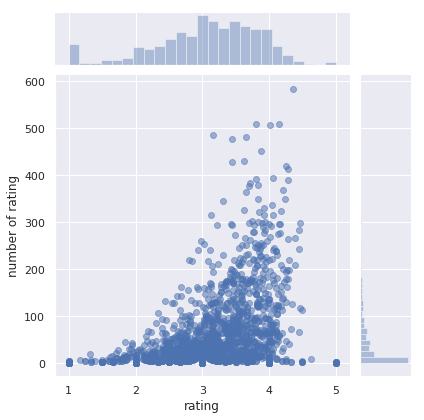

In [0]:
sns.jointplot(x='rating',y='number of rating',data=ratings,alpha=0.5)


In [0]:
# for each user all the movies 
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
similar_to_terminator = moviemat.corrwith(terminator_user_ratings)
terminator_user_ratings = moviemat["Terminator, The (1984)"]
corr_terminator = pd.DataFrame(similar_to_terminator,columns=['Correlation'])
corr_terminator.dropna(inplace=True)
corr_terminator.head()

corr_terminator = corr_terminator.join(ratings['number of rating'])
corr_terminator[corr_terminator['number of rating']>100].sort_values('Correlation',ascending=False).head()

,Correlation,number of rating
title,,
"Terminator, The (1984)",1.000000,301
Terminator 2: Judgment Day (1991),0.562853,295
Young Guns (1988),0.473208,101
Scream 2 (1997),0.428092,106
"Frighteners, The (1996)",0.427170,115


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Book Recommendedtion base on Embedding
Hybrid exmple

In [0]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

warnings.filterwarnings('ignore')

In [0]:
dataset = pd.read_csv('ratings.csv')
dataset.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [0]:

dataset.shape

(981756, 3)

In [0]:
n_users = len(dataset.user_id.unique())
n_books = len(dataset.book_id.unique())

(n_books, n_users)

(10000, 53424)

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [0]:
# creating book embedding path
book_input = Input(shape=[1], name="Book-Input")
book_embedding = Embedding(n_books+1, 5, name="Book-Embedding")(book_input)
book_vec = Flatten(name="Flatten-Books")(book_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([book_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([user_input, book_input], out)
model2.compile('adam', 'mean_squared_error')

![alt text](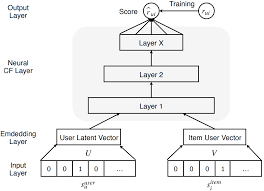
)

Epoch 1/5
785404/785404 [==============================] - 133s 169us/step - loss: 0.8050
Epoch 2/5
785404/785404 [==============================] - 134s 170us/step - loss: 0.6879
Epoch 3/5
785404/785404 [==============================] - 132s 168us/step - loss: 0.6603
Epoch 4/5
785404/785404 [==============================] - 135s 172us/step - loss: 0.6350
Epoch 5/5
785404/785404 [==============================] - 133s 170us/step - loss: 0.6133


Text(0, 0.5, 'Training Error')

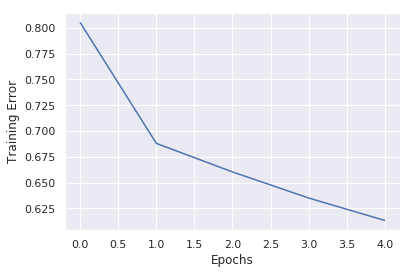

In [0]:
history = model2.fit([train.user_id, train.book_id], train.rating, epochs=5, verbose=1)
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [0]:
# Creating dataset for making recommendations for the first user
book_data = np.array(list(set(dataset.book_id)))
book_data[:5]

array([1, 2, 3, 4, 5])

In [0]:
user_id = 9 
user = np.array([user_id for i in range(len(book_data))])
user[:5]

array([9, 9, 9, 9, 9])

In [0]:
predictions = model2.predict([user, book_data])

predictions = np.array([a[0] for a in predictions]) # a[0] - Only 1 value in the array

recommended_book_ids = (-predictions).argsort()[:5] # 5 the best

recommended_book_ids

array([3627, 8945, 9841, 7946, 4867])

In [0]:
# print predicted scores
predictions[recommended_book_ids]

array([4.624472 , 4.581929 , 4.5296235, 4.515876 , 4.505091 ],
      dtype=float32)

In [0]:
books = pd.read_csv('books.csv')
books[books['id'].isin(recommended_book_ids)]

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3626,3627,7592279,7592279,9985502,37,1741664489,9.781742e+12,John Flanagan,2011.0,NaN,"The Emperor of Nihon-Ja (Ranger's Apprentice, ...",eng,4.42,29397,33357,1089,226,618,3569,9564,19380,https://images.gr-assets.com/books/1446448563m...,https://images.gr-assets.com/books/1446448563s...
4866,4867,5215879,5215879,5283119,31,425227723,9.780425e+12,Laurell K. Hamilton,2009.0,Skin Trade,"Skin Trade (Anita Blake, Vampire Hunter #17)",en-US,3.90,29261,31383,1081,952,2377,6995,9455,11604,https://images.gr-assets.com/books/1310494564m...,https://images.gr-assets.com/books/1310494564s...
7945,7946,39926,39926,836516,43,60512180,9.780061e+12,Naomi Wolf,1990.0,The Beauty Myth: How Images of Beauty Are Used...,The Beauty Myth,eng,3.89,13037,14266,790,234,790,3493,5552,4197,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
8944,8945,32529,32529,3214115,40,752848267,9.780753e+12,Lisa Gardner,2001.0,The Next Accident,"The Next Accident (Quincy & Rainie, #3)",en-US,4.16,11261,13328,513,49,231,2323,5612,5113,https://images.gr-assets.com/books/1348816896m...,https://images.gr-assets.com/books/1348816896s...
9840,9841,15101,15101,876908,55,380815923,9.780381e+12,Joanne Harris,1999.0,Blackberry Wine,Blackberry Wine,en-US,3.78,9558,11107,699,163,755,3215,4220,2754,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...


In [0]:
user_books = dataset[dataset["user_id"] == user_id]
user_books

,book_id,user_id,rating
438549,4394,9,3
477693,4788,9,4
588412,5908,9,3
674148,6777,9,3
723685,7285,9,3
780343,7868,9,2
857835,8676,9,4


In [0]:
 books[books['id'].isin(user_books.book_id)].head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
4393,4394,139220,139220,996750,38,1400041201,9.781400e+12,Bill Buford,2006.0,Heat,Heat: An Amateur's Adventures as Kitchen Slave...,NaN,3.89,18583,20010,1818,245,1078,4899,8227,5561,https://images.gr-assets.com/books/1320554917m...,https://images.gr-assets.com/books/1320554917s...
4787,4788,9799,9799,1971520,37,571219357,9.780571e+12,Jonathan Lethem,2003.0,The Fortress of Solitude,The Fortress of Solitude,eng,3.87,15100,18114,1369,421,1188,3995,7181,5329,https://images.gr-assets.com/books/1418677318m...,https://images.gr-assets.com/books/1418677318s...
5907,5908,531262,531262,3115332,76,316926051,9.780317e+12,Evelyn Waugh,1934.0,A Handful of Dust,A Handful of Dust,en-US,3.92,17370,19093,907,279,919,4544,7707,5644,https://images.gr-assets.com/books/1344266314m...,https://images.gr-assets.com/books/1344266314s...
6776,6777,89691,89691,1585061,48,316778508,9.780317e+12,Carolyn Parkhurst,2003.0,The Dogs of Babel,The Dogs of Babel,eng,3.56,14966,16181,2072,697,1748,4870,5528,3338,https://images.gr-assets.com/books/1344269639m...,https://images.gr-assets.com/books/1344269639s...
7284,7285,1474628,1474628,2881737,44,434017841,9.780434e+12,Lauren Groff,2008.0,The Monsters of Templeton,The Monsters of Templeton,eng,3.58,13849,15878,2465,446,1538,4937,6241,2716,https://images.gr-assets.com/books/1328051913m...,https://images.gr-assets.com/books/1328051913s...


_______________________

# Movie recommendedtion base on movie genre  
context exmple

In [0]:
from tqdm import tqdm

In [0]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [0]:
data = ratings.join(movies.set_index('movieID'), on='movieID')
data.head()

,userID,movieID,rating,timestamp,title,genres
0,1,31,2.5,1260759144,Dangerous Minds (1995),Drama
1,1,1029,3.0,1260759179,Dumbo (1941),Animation|Children|Drama|Musical
2,1,1061,3.0,1260759182,Sleepers (1996),Thriller
3,1,1129,2.0,1260759185,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
4,1,1172,4.0,1260759205,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [0]:
# small data cleaning 
data = data.groupby('userID').filter(lambda grp: len(grp)<500)

In [0]:
# decrease the data by memory issues 
data = data.sample(10000)

In [0]:
df_item = data[['movieID','genres']]
df_item.head()

,movieID,genres
15312,1036,Action|Crime|Thriller
71443,2959,Action|Crime|Drama|Thriller
76644,1282,Animation|Children|Fantasy|Musical
37759,1552,Action|Adventure|Thriller
9744,953,Children|Drama|Fantasy|Romance


In [0]:
df_genre = df_item.genres.str.get_dummies('|')
df_genre["movieID"] = df_item.movieID
df_genre.head()

data = data.drop(labels = "genres", axis = 1)

In [0]:
data = data.join(df_genre.set_index('movieID'), on='movieID')
data = data.dropna(subset = ["title"])
data.head()

,userID,movieID,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
15312,101,1036,3.5,1292402569,Die Hard (1988),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
15312,101,1036,3.5,1292402569,Die Hard (1988),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
15312,101,1036,3.5,1292402569,Die Hard (1988),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
15312,101,1036,3.5,1292402569,Die Hard (1988),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
15312,101,1036,3.5,1292402569,Die Hard (1988),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
rating = pd.pivot_table(data, values='rating', index=['userID'], columns = ['movieID'])
rating.head()

movieID,1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,29,31,32,34,35,36,39,40,41,43,44,45,46,47,48,50,...,120466,122882,122886,122888,122900,122904,122920,128512,129191,130087,130580,131724,132046,133419,134170,134368,134783,134853,135887,136016,136445,136449,136562,136598,136864,137857,138036,139644,140265,140711,140761,140880,144976,145935,148626,149354,152077,152081,153584,159093
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
users_no = rating.columns
df_users = pd.DataFrame(columns = df_genre.columns)
df_users

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieID


In [0]:
# tqdm is just for nice progress bar , tqdm - is progress in arbic lol 
for i in tqdm(range(len(users_no))):
    working_df = df_genre.mul(rating.iloc[:,i], axis=0)
    working_df.replace(0, np.NaN, inplace=True)    
    df_users.loc[users_no[i]] = working_df.mean(axis=0)

100%|██████████| 3050/3050 [00:28<00:00, 104.89it/s]


In [0]:
df_users.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movieID
1,NaN,3.75,3.833333,4.0,3.666667,3.666667,NaN,NaN,3.75,4.0,NaN,NaN,4.0,NaN,3.5,NaN,4.0,3.5,NaN,NaN,25916.833333
2,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,12944.500000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,9985.000000
5,NaN,3.00,3.000000,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,1560.000000
6,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN,3.50,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,3.0,NaN,4560.000000


In [0]:
document_frequency = df_genre.sum()
idf = 1/document_frequency

In [0]:
#make an empty dataframe
df_predict = pd.DataFrame()

#The dot product of article vectors and IDF vectors gives us the weighted scores of each article.
idf_df_item = df_genre.mul(idf)

In [0]:
#user predict by tfidf
for i in tqdm(range(len(users_no))):
    working_df = idf_df_item.mul(df_users.iloc[i], axis=1)
    df_predict[users_no[i]] = working_df.sum(axis=1)

100%|██████████| 3050/3050 [00:48<00:00, 63.29it/s]


In [0]:

#all user score predict of all books
df_predict.head()

,1,2,3,5,6,7,8,9,10,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,29,31,32,34,35,36,39,40,41,43,44,45,46,47,48,50,...,120466,122882,122886,122888,122900,122904,122920,128512,129191,130087,130580,131724,132046,133419,134170,134368,134783,134853,135887,136016,136445,136449,136562,136598,136864,137857,138036,139644,140265,140711,140761,140880,144976,145935,148626,149354,152077,152081,153584,159093
15312,0.245782,0.126360,0.093676,0.015672,0.042781,0.020152,0.0,0.0,0.053136,0.094441,0.0,0.0,0.0,0.048761,0.0,0.021571,0.035407,0.0,0.0,0.016465,0.0,0.098434,0.021953,0.0,0.129814,0.0,0.025190,0.414858,0.0,0.055244,0.060198,0.0,0.159864,0.056206,0.056206,0.0,0.0,0.059436,0.031305,0.060497,...,0.0,0.088300,0.060412,0.0,0.0,0.0,0.075133,0.0,0.0,0.0,0.0,0.090304,0.0,0.0,0.0,0.0,0.0,0.009983,0.0,0.0,0.0,0.110375,0.0,0.0,0.068233,0.0,0.0,0.077294,0.0,0.0,0.0,0.0,0.0,0.0,0.113115,0.068233,0.087728,0.0,0.0,0.0
71443,0.697966,0.352238,0.267556,0.042838,0.122997,0.058481,0.0,0.0,0.146673,0.270086,0.0,0.0,0.0,0.139271,0.0,0.058401,0.101127,0.0,0.0,0.047027,0.0,0.272412,0.062702,0.0,0.369450,0.0,0.073101,1.177604,0.0,0.145449,0.161826,0.0,0.457755,0.160534,0.160534,0.0,0.0,0.164008,0.084693,0.164005,...,0.0,0.248667,0.167983,0.0,0.0,0.0,0.205956,0.0,0.0,0.0,0.0,0.258962,0.0,0.0,0.0,0.0,0.0,0.019735,0.0,0.0,0.0,0.310834,0.0,0.0,0.194886,0.0,0.0,0.210895,0.0,0.0,0.0,0.0,0.0,0.0,0.323770,0.194886,0.250567,0.0,0.0,0.0
76644,0.314499,0.150278,0.115920,0.018111,0.052939,0.024937,0.0,0.0,0.065013,0.116866,0.0,0.0,0.0,0.085589,0.0,0.030060,0.043814,0.0,0.0,0.020374,0.0,0.115293,0.027166,0.0,0.159142,0.0,0.031171,0.515449,0.0,0.060137,0.067752,0.0,0.197824,0.069552,0.069552,0.0,0.0,0.092119,0.049308,0.068389,...,0.0,0.106296,0.090618,0.0,0.0,0.0,0.106120,0.0,0.0,0.0,0.0,0.123500,0.0,0.0,0.0,0.0,0.0,0.006501,0.0,0.0,0.0,0.132870,0.0,0.0,0.100976,0.0,0.0,0.089067,0.0,0.0,0.0,0.0,0.0,0.0,0.139975,0.100976,0.129827,0.0,0.0,0.0
37759,0.368504,0.183845,0.140334,0.024229,0.064088,0.030189,0.0,0.0,0.078235,0.141479,0.0,0.0,0.0,0.073048,0.0,0.033566,0.053041,0.0,0.0,0.024666,0.0,0.142260,0.032887,0.0,0.193868,0.0,0.037736,0.618604,0.0,0.076447,0.085667,0.0,0.239488,0.084200,0.084200,0.0,0.0,0.089212,0.046713,0.087754,...,0.0,0.128682,0.087776,0.0,0.0,0.0,0.108136,0.0,0.0,0.0,0.0,0.137182,0.0,0.0,0.0,0.0,0.0,0.011711,0.0,0.0,0.0,0.160853,0.0,0.0,0.102218,0.0,0.0,0.110742,0.0,0.0,0.0,0.0,0.0,0.0,0.169454,0.102218,0.131423,0.0,0.0,0.0
9744,0.232108,0.112174,0.086171,0.015978,0.041670,0.019461,0.0,0.0,0.050519,0.087976,0.0,0.0,0.0,0.053793,0.0,0.023759,0.032570,0.0,0.0,0.015146,0.0,0.086744,0.022709,0.0,0.119225,0.0,0.024326,0.384954,0.0,0.044704,0.050365,0.0,0.148211,0.051703,0.051703,0.0,0.0,0.062301,0.030111,0.051762,...,0.0,0.079941,0.057715,0.0,0.0,0.0,0.069239,0.0,0.0,0.0,0.0,0.089064,0.0,0.0,0.0,0.0,0.0,0.004833,0.0,0.0,0.0,0.099926,0.0,0.0,0.066621,0.0,0.0,0.066210,0.0,0.0,0.0,0.0,0.0,0.0,0.104745,0.066621,0.085656,0.0,0.0,0.0


In [0]:
def recommender_1(user_no):
    
    #get all book isbn
    isbn_no = df_predict.index
    
    #user predicted rating to all books
    user_predicted_rating = df_predict[user_no]
    
    #combine book rating and book detail
    user_rating_book_detail = pd.concat([user_predicted_rating,movies.set_index('movieID')], axis=1)
    user_rating_book_detail = user_rating_book_detail.dropna(subset = ["title"])

    #sort top 10 rating books
    return user_rating_book_detail.sort_values(by=[user_no], ascending=False).iloc[0:10]

In [0]:
#input the user number (e.g. 11676) to get top 10 books recommendation
recommender_1(1)

,1,title,genres
6872,35.706597,"House of the Dead, The (2003)",Action|Horror
37720,35.057626,"Exorcism of Emily Rose, The (2005)",Crime|Drama|Horror|Thriller
85022,28.861420,Hall Pass (2011),Comedy
6765,25.857541,Under the Tuscan Sun (2003),Comedy|Drama|Romance
6763,25.247575,Duplex (2003),Comedy|Crime
7136,25.063024,Stolen Kisses (Baisers volés) (1968),Comedy|Drama|Romance
78264,25.058297,"Back-up Plan, The (2010)",Comedy|Romance
47810,24.901991,"Wicker Man, The (2006)",Horror|Mystery|Thriller
27397,21.496066,Joint Security Area (Gongdong gyeongbi guyeok ...,Crime|Drama|Mystery|Thriller|War
84772,21.066842,Paul (2011),Adventure|Comedy|Sci-Fi


# distance as similarity:
exmple to find to closet user

In [0]:
from scipy import spatial

a = [1, 2]
b = [2, 4]
c = [2.5, 4]
d = [4.5, 5]

print("c and a:",spatial.distance.euclidean(c, a))
print("c and b:",spatial.distance.euclidean(c, b))
print("c and d:",spatial.distance.euclidean(c, d))

c and a: 2.5
c and b: 0.5
c and d: 2.23606797749979


In [0]:
print("c and a:",spatial.distance.cosine(c,a))
print("c and b:",spatial.distance.cosine(c,b))
print("c and d:",spatial.distance.cosine(c,d))
print("a and a:",spatial.distance.cosine(a,b))

# יחס בינהם 

c and a: 0.004504527406047898
c and b: 0.004504527406047898
c and d: 0.015137225946083022
a and a: 0.0


![alt text](https://files.realpython.com/media/cosine-similarity.76bcd5413eb8.jpg)

# Recommendedtion use Matrix factorization
Collaborative filtering

Check - https://colab.research.google.com/drive/1Q9gmQ87rAKfKvxBmSh4v9zqcmuJu37tq#scrollTo=VqanuQL6B4IB

 # Movies recommndation base on user KNN
Collaborative filtering

les take the "Movie recommendedtion base on books genre" data , with the content base model, and add to it an user-user modle

In [0]:
# start with the rating table: 
rating_user = pd.pivot_table(data, values='rating', index=['movieID'], columns = ['userID'])

# fill unknown rating with avreage (see also ppl do it with 0, but I think it not work well)
rating_user.fillna(value = rating_user.mean(), inplace = True)
rating_user.head()

userID,1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,...,629,630,631,632,633,634,635,636,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,655,656,657,658,659,660,661,662,663,665,666,667,668,669,670,671
movieID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.4,3.388889,3.375,4.459459,3.75,2.3,3.2,3.75,4.0,3.666667,4.2,3.285714,3.777778,3.833333,3.663934,3.777778,3.596774,3.5,3.518519,3.092593,5.0,3.3,3.8,4.0,1.8,4.09375,3.25,3.416667,4.2,4.25,3.636364,4.5,4.307692,3.8,4.5625,3.875,4.25,2.692308,4.0,3.166667,...,3.571429,4.000,3.0,4.5,3.0,3.0,3.2,3.0,2.75,3.333333,4.0,4.235294,3.857143,3.833333,4.0,3.214286,4.423077,4.178571,3.544118,3.166667,3.166667,4.333333,4.413793,4.1,3.888889,4.368421,3.333333,4.5,3.380952,4.133333,3.8,3.5,4.000000,3.132353,2.666667,4.111111,4.333333,3.0,3.4,3.833333
2,2.4,3.388889,3.375,4.459459,3.75,2.3,3.2,3.75,3.4,3.666667,4.2,3.285714,3.777778,3.833333,3.663934,3.777778,3.596774,3.3,3.518519,3.092593,5.0,3.3,3.8,4.0,1.8,4.09375,3.25,3.416667,4.2,4.25,3.636364,4.5,4.307692,3.8,4.5625,3.875,4.25,2.692308,4.0,3.166667,...,3.571429,4.125,3.0,4.5,3.0,3.0,3.2,3.0,2.75,3.333333,4.0,4.235294,3.857143,3.833333,4.0,3.214286,4.423077,4.178571,3.544118,3.166667,3.166667,4.333333,4.413793,4.1,3.888889,4.368421,3.333333,4.5,3.380952,4.133333,3.8,5.0,3.722222,3.132353,2.666667,4.111111,4.333333,3.0,3.4,3.833333
3,2.4,3.388889,3.375,4.459459,3.75,2.3,3.2,3.75,3.4,3.666667,4.2,3.285714,3.777778,3.833333,3.663934,3.777778,3.000000,3.3,3.518519,3.092593,5.0,3.3,3.8,4.0,1.8,4.09375,3.25,3.416667,4.2,4.25,3.636364,4.5,4.307692,3.8,4.5625,3.875,4.25,2.692308,5.0,3.166667,...,3.571429,4.125,3.0,4.5,3.0,3.0,3.2,3.0,2.75,3.333333,4.0,4.235294,3.857143,3.833333,4.0,3.214286,4.423077,4.178571,3.544118,3.166667,3.166667,4.333333,4.413793,4.1,3.888889,4.368421,3.333333,4.5,3.380952,4.133333,3.8,3.5,3.722222,3.132353,2.666667,4.111111,4.333333,3.0,3.4,3.833333
5,2.4,3.388889,3.375,4.459459,3.75,2.3,3.2,3.75,3.4,3.666667,4.2,3.285714,3.777778,3.833333,3.663934,3.777778,3.596774,3.3,3.518519,3.092593,5.0,3.3,3.8,4.0,1.8,4.09375,3.25,3.416667,4.2,4.25,3.636364,4.5,4.307692,3.8,4.5625,3.875,4.25,2.692308,4.0,3.166667,...,3.571429,4.125,3.0,4.5,3.0,3.0,3.2,3.0,2.75,3.333333,4.0,4.235294,3.857143,3.833333,4.0,3.214286,4.423077,4.178571,3.544118,3.166667,3.166667,4.333333,4.413793,4.1,3.888889,4.368421,3.333333,4.5,3.380952,4.133333,3.8,3.5,3.722222,3.000000,2.666667,4.111111,4.333333,3.0,3.4,3.833333
6,2.4,3.388889,3.375,4.459459,3.75,2.3,3.2,3.75,3.4,3.666667,4.2,3.285714,3.777778,3.833333,3.663934,4.000000,3.596774,3.3,3.518519,3.092593,5.0,3.3,3.8,4.0,1.8,4.09375,3.25,3.416667,4.2,4.25,3.636364,4.5,4.307692,3.8,4.5625,3.875,4.25,2.692308,4.0,3.166667,...,3.571429,4.125,3.0,4.5,3.0,3.0,3.2,3.0,2.75,3.333333,4.0,4.235294,3.857143,3.833333,4.0,3.214286,4.423077,4.178571,3.544118,3.166667,3.166667,4.333333,4.413793,4.1,3.888889,4.368421,3.333333,4.5,3.380952,4.133333,3.8,3.5,3.722222,3.132353,2.666667,4.111111,4.333333,3.0,3.4,3.833333


In [0]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” 
# so that the algorithm will calculate the cosine similarity between rating vectors.

model_knn = NearestNeighbors(metric = 'cosine', algorithm='brute')
model_knn.fit(csr_matrix(rating_user))


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
user_id = 1
print("User id:",user_id)
distance ,closet_neighbors = model_knn.kneighbors(rating_user.iloc[[user_id]],n_neighbors=6)

print("distance:",distance)
print("closet_neighbors:",closet_neighbors)

User id: 1
distance: [[8.88178420e-16 4.32878733e-04 4.44099649e-04 4.47232571e-04
  4.50453746e-04 4.90315036e-04]]
closet_neighbors: [[   1 2199  119 2500  403 1634]]


In [0]:
user_love_movies = ratings[ratings["userID"] == user_id].sort_values("rating",ascending = False)[:10].movieID
movies.iloc[user_love_movies]

,movieID,title,genres
1172,1447,Gridlock'd (1997),Crime
2105,2630,Besieged (a.k.a. L' Assedio) (1998),Drama
1953,2445,At First Sight (1999),Drama
1339,1686,Red Corner (1997),Crime|Thriller
3671,4681,"War of the Roses, The (1989)",Comedy|Drama
1029,1275,Highlander (1986),Action|Adventure|Fantasy
1061,1310,Hype! (1996),Documentary
2150,2688,"General's Daughter, The (1999)",Crime|Drama|Mystery|Thriller
2455,3054,Pokémon: The First Movie (1998),Adventure|Animation|Children|Fantasy|Sci-Fi
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


In [0]:
movies.iloc[closet_neighbors.flatten()]

,movieID,title,genres
1,2,Jumanji (1995),Adventure|Children|Fantasy
2199,2747,"Little Shop of Horrors, The (1960)",Comedy|Horror
119,135,Down Periscope (1996),Comedy
2500,3108,"Fisher King, The (1991)",Comedy|Drama|Fantasy|Romance
403,454,"Firm, The (1993)",Drama|Thriller
1634,2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance


# Hybrid movie recommended Base genre and KNN
Hybrid exmple

In [0]:
# less take user 1
userId = 1

In [0]:
# take recommendedtion from the movie contex - "Movie recommendedtion base on movie genre"
contex_recommended = recommender_1(userId)
contex_recommended

,1,title,genres
6872,35.706597,"House of the Dead, The (2003)",Action|Horror
37720,35.057626,"Exorcism of Emily Rose, The (2005)",Crime|Drama|Horror|Thriller
85022,28.861420,Hall Pass (2011),Comedy
6765,25.857541,Under the Tuscan Sun (2003),Comedy|Drama|Romance
6763,25.247575,Duplex (2003),Comedy|Crime
7136,25.063024,Stolen Kisses (Baisers volés) (1968),Comedy|Drama|Romance
78264,25.058297,"Back-up Plan, The (2010)",Comedy|Romance
47810,24.901991,"Wicker Man, The (2006)",Horror|Mystery|Thriller
27397,21.496066,Joint Security Area (Gongdong gyeongbi guyeok ...,Crime|Drama|Mystery|Thriller|War
84772,21.066842,Paul (2011),Adventure|Comedy|Sci-Fi


In [0]:
# take recommendedtion from the user-user - "Movies recommndation base on user KNN"
distance ,closet_neighbors = model_knn.kneighbors(rating_user.iloc[[user_id]],n_neighbors=10)
knn_recommended = movies.iloc[closet_neighbors.flatten()]
knn_recommended.set_index("movieID",inplace = True)
knn_recommended

,title,genres
movieID,,
2,Jumanji (1995),Adventure|Children|Fantasy
2747,"Little Shop of Horrors, The (1960)",Comedy|Horror
135,Down Periscope (1996),Comedy
3108,"Fisher King, The (1991)",Comedy|Drama|Fantasy|Romance
454,"Firm, The (1993)",Drama|Thriller
2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance
1998,Exorcist II: The Heretic (1977),Horror
2215,Rich and Strange (1931),Comedy|Romance
984,"Pompatus of Love, The (1996)",Comedy|Drama


In [0]:
recommended_movies = pd.concat([knn_recommended,contex_recommended])
recommended_movies.drop([1], axis = 1,inplace = True)
recommended_movies

,title,genres
2,Jumanji (1995),Adventure|Children|Fantasy
2747,"Little Shop of Horrors, The (1960)",Comedy|Horror
135,Down Periscope (1996),Comedy
3108,"Fisher King, The (1991)",Comedy|Drama|Fantasy|Romance
454,"Firm, The (1993)",Drama|Thriller
2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance
1998,Exorcist II: The Heretic (1977),Horror
2215,Rich and Strange (1931),Comedy|Romance
984,"Pompatus of Love, The (1996)",Comedy|Drama
96,In the Bleak Midwinter (1995),Comedy|Drama


In [0]:
# let try to find what is the most recommended movie by all users.
movie_mean_rating = ratings.set_index("movieID").groupby("movieID").mean()["rating"]
movie_mean_rating[recommended_movies.index]

2        3.401869
2747     3.035714
135      3.000000
3108     3.635135
454      3.472727
2074     4.000000
1998     3.500000
2215     4.000000
984      4.500000
96       1.000000
6872     0.500000
37720    3.250000
85022    2.700000
6765     3.333333
6763     2.166667
7136     4.250000
78264    2.000000
47810    1.000000
27397    4.000000
84772    2.812500
Name: rating, dtype: float64

In [0]:
recommended_movies["mean_rating"] = movie_mean_rating
recommended_movies.sort_index(by ="mean_rating",axis=0,ascending=False)

,title,genres,mean_rating
984,"Pompatus of Love, The (1996)",Comedy|Drama,4.500000
7136,Stolen Kisses (Baisers volés) (1968),Comedy|Drama|Romance,4.250000
2074,"Night Porter, The (Portiere di notte, Il) (1974)",Crime|Drama|Romance,4.000000
2215,Rich and Strange (1931),Comedy|Romance,4.000000
27397,Joint Security Area (Gongdong gyeongbi guyeok ...,Crime|Drama|Mystery|Thriller|War,4.000000
3108,"Fisher King, The (1991)",Comedy|Drama|Fantasy|Romance,3.635135
1998,Exorcist II: The Heretic (1977),Horror,3.500000
454,"Firm, The (1993)",Drama|Thriller,3.472727
2,Jumanji (1995),Adventure|Children|Fantasy,3.401869
6765,Under the Tuscan Sun (2003),Comedy|Drama|Romance,3.333333


In [0]:
# and now we can do 2 thing
# or give the user the best movies, or remove the worst (it the same but diffrent)

# in this way we can combin how much recommendation system that we want. (get all the results).

# other way, is the check the overlapping result 

# Games Recommendedtion project - How to create rating

In [0]:
users = pd.read_csv('steam-200k.csv')

In [0]:
users.head()

,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
0,151603712,The Elder Scrolls V Skyrim,play,273.0,0
1,151603712,Fallout 4,purchase,1.0,0
2,151603712,Fallout 4,play,87.0,0
3,151603712,Spore,purchase,1.0,0
4,151603712,Spore,play,14.9,0


In [0]:
# about the data
# 151603712 - User ID
# The Elder Scrolls V SkyrimName of the steam game
# purchase - behavior name (purchase/play)
# 1.0 - Hours if behavior is play, 1.0 if behavior is purchase


users.rename(columns = {'151603712':'user_id',
                         'The Elder Scrolls V Skyrim':'item_name',
                        '1.0':'play_time'},inplace = True)

users.drop(columns = "0",axis = 1,inplace = True)
users.head()

,user_id,item_name,purchase,play_time
0,151603712,The Elder Scrolls V Skyrim,play,273.0
1,151603712,Fallout 4,purchase,1.0
2,151603712,Fallout 4,play,87.0
3,151603712,Spore,purchase,1.0
4,151603712,Spore,play,14.9


In [0]:
# create item table
games = pd.DataFrame(users['item_name'].astype('category'))
games['item_id'] = games['item_name'].cat.codes
games.head()

,item_name,item_id
0,The Elder Scrolls V Skyrim,4364
1,Fallout 4,1678
2,Fallout 4,1678
3,Spore,3997
4,Spore,3997


In [0]:
users.drop(columns = "item_name",axis = 1,inplace = True)
users['item_id'] = games['item_id']
games.drop_duplicates(inplace = True)
users.head()

,user_id,purchase,play_time,item_id
0,151603712,play,273.0,4364
1,151603712,purchase,1.0,1678
2,151603712,play,87.0,1678
3,151603712,purchase,1.0,3997
4,151603712,play,14.9,3997


Max user games play: 1573
Max user play time for game: 11908.699999999999
Play time mean: 30.717079534587185
Games play mean: 16.138061809085773


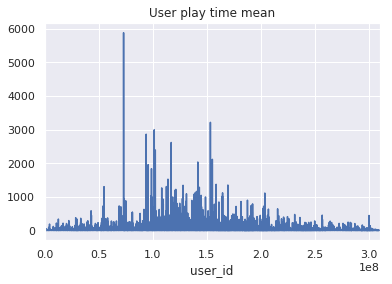

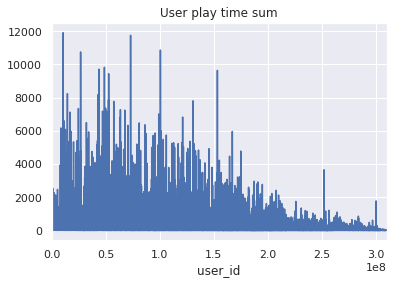

In [0]:
users_gb = users.groupby('user_id')
print("Max user games play:",users_gb.size().max())
print("Max user play time for game:",users_gb.sum()['play_time'].max())
print("Play time mean:",users_gb.mean()["play_time"].mean())
print("Games play mean:",users_gb.size().mean())

users_gb.mean()["play_time"].plot(title = "User play time mean")
plt.show()

users_gb.sum()["play_time"].plot(title = "User play time sum")
plt.show()

In [0]:
users_play = users[users['purchase'] == 'play']
games_play_time_mean = users_play.groupby('item_id').mean()['play_time']
games_play_time_mean.head()


item_id
0    0.70
1    0.40
2    4.00
3    2.95
4    3.60
Name: play_time, dtype: float64

In [0]:
def getGameMeanPlayTime(itemId):
  if itemId in games_play_time_mean.index:
    return games_play_time_mean[itemId]
  # if there is no playtime data, return the mean
  return games_play_time_mean.median()

users['mean_play_time'] = users['item_id'].apply(getGameMeanPlayTime)
users.head()

,user_id,purchase,play_time,item_id,mean_play_time
0,151603712,play,273.0,4364,104.710931
1,151603712,purchase,1.0,1678,64.447904
2,151603712,play,87.0,1678,64.447904
3,151603712,purchase,1.0,3997,29.424138
4,151603712,play,14.9,3997,29.424138


Create rating realed to the mean play time

In [0]:
# les build a rating for each user selecting

# Only for play 
# formola: P\MP
# when P = play time, MP = mean play time 
# and after with scale all the 0-1 

# for purchase = 1

users['rating'] = users['play_time']/users['mean_play_time']

In [0]:
users['rating'].max()

128.94163927327924

In [0]:
users['rating'] = users.apply(lambda row: 150 if row['purchase'] == 'purchase' else row['rating'] , axis=1)

In [0]:
users['rating'] = users['rating'] / users['rating'].max()

bigger then 0.5:  129511
less then 0.5:  70488


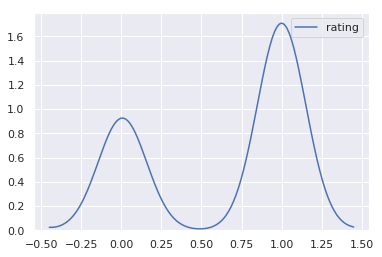

In [0]:
print("bigger then 0.5: ",(users['rating'] > 0.5).sum())
print("less then 0.5: ",(users['rating'] < 0.5).sum())

sns.kdeplot(users['rating'], bw=.15)

In [0]:
users.head()

,user_id,purchase,play_time,item_id,mean_play_time,rating
0,151603712,play,273.0,4364,104.710931,0.017381
1,151603712,purchase,1.0,1678,64.447904,1.000000
2,151603712,play,87.0,1678,64.447904,0.009000
3,151603712,purchase,1.0,3997,29.424138,1.000000
4,151603712,play,14.9,3997,29.424138,0.003376


Let start Recoomended!!! 

In [0]:
# start with the rating table: 
rating_user = pd.pivot_table(users, values='rating', index=['item_id'], columns = ['user_id'])


# fill unknown rating with avreage (see also ppl do it with 0, but I think it not work well)
rating_user.fillna(value = rating_user.mean(), inplace = True)
rating_user.head()

user_id,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,547685,554278,561758,577614,604988,622362,635733,683019,714122,748719,835015,861238,871990,937567,948368,975449,976129,983600,994489,1006880,1024319,1072465,1129452,1135775,1268792,1364546,1423371,1601069,1601773,1603625,...,308653033,308691324,308692673,308695132,308760273,308770654,308819212,308851352,308851621,308880998,308894258,308925132,308925147,308940605,308954355,308970742,308971716,308997600,309038666,309052991,309058572,309107542,309138595,309167186,309181805,309188905,309213952,309216884,309228590,309255941,309262440,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.858601,0.724237,0.909046,1.0,0.9375,0.916775,0.667898,0.663439,1.0,0.950004,0.90031,0.839605,0.723803,0.937563,1.0,0.800168,0.937501,0.923286,0.850007,0.751067,1.0,0.833632,0.875278,0.941188,0.893015,0.734117,0.937501,0.958447,0.870438,1.0,0.937851,0.800267,0.71423,0.937502,0.937501,0.889819,0.944825,1.0,1.0,1.0,...,0.750066,0.500138,0.500048,0.500831,0.500277,0.500013,0.500105,1.0,0.501605,0.500027,0.50003,0.500062,1.0,0.500095,0.500067,0.500183,0.502276,0.500468,0.500038,0.666799,0.500085,0.50011,0.500013,0.500182,0.750756,0.501017,0.500227,0.500066,0.500005,0.505138,0.833351,0.500649,1.0,0.501007,0.500013,0.505318,0.500651,1.0,0.500012,0.500003
1,0.858601,0.724237,0.909046,1.0,0.9375,0.916775,0.667898,0.663439,1.0,0.950004,0.90031,0.839605,0.723803,0.937563,1.0,0.800168,0.937501,0.923286,0.850007,0.751067,1.0,0.833632,0.875278,0.941188,0.893015,0.734117,0.937501,0.958447,0.870438,1.0,0.937851,0.800267,0.71423,0.937502,0.937501,0.889819,0.944825,1.0,1.0,1.0,...,0.750066,0.500138,0.500048,0.500831,0.500277,0.500013,0.500105,1.0,0.501605,0.500027,0.50003,0.500062,1.0,0.500095,0.500067,0.500183,0.502276,0.500468,0.500038,0.666799,0.500085,0.50011,0.500013,0.500182,0.750756,0.501017,0.500227,0.500066,0.500005,0.505138,0.833351,0.500649,1.0,0.501007,0.500013,0.505318,0.500651,1.0,0.500012,0.500003
2,0.858601,0.724237,0.909046,1.0,0.9375,0.916775,0.667898,0.663439,1.0,0.950004,0.90031,0.839605,0.723803,0.937563,1.0,0.800168,0.937501,0.923286,0.850007,0.751067,1.0,0.833632,0.875278,0.941188,0.893015,0.734117,0.937501,0.958447,0.870438,1.0,0.937851,0.800267,0.71423,0.937502,0.937501,0.889819,0.944825,1.0,1.0,1.0,...,0.750066,0.500138,0.500048,0.500831,0.500277,0.500013,0.500105,1.0,0.501605,0.500027,0.50003,0.500062,1.0,0.500095,0.500067,0.500183,0.502276,0.500468,0.500038,0.666799,0.500085,0.50011,0.500013,0.500182,0.750756,0.501017,0.500227,0.500066,0.500005,0.505138,0.833351,0.500649,1.0,0.501007,0.500013,0.505318,0.500651,1.0,0.500012,0.500003
3,0.858601,0.724237,0.909046,1.0,0.9375,0.916775,0.667898,0.663439,1.0,0.950004,0.90031,0.839605,0.723803,0.937563,1.0,0.800168,0.937501,0.923286,0.850007,0.751067,1.0,0.833632,0.875278,0.941188,0.893015,0.734117,0.937501,0.958447,0.870438,1.0,0.937851,0.800267,0.71423,0.937502,0.937501,0.889819,0.944825,1.0,1.0,1.0,...,0.750066,0.500138,0.500048,0.500831,0.500277,0.500013,0.500105,1.0,0.501605,0.500027,0.50003,0.500062,1.0,0.500095,0.500067,0.500183,0.502276,0.500468,0.500038,0.666799,0.500085,0.50011,0.500013,0.500182,0.750756,0.501017,0.500227,0.500066,0.500005,0.505138,0.833351,0.500649,1.0,0.501007,0.500013,0.505318,0.500651,1.0,0.500012,0.500003
4,0.858601,0.724237,0.909046,1.0,0.9375,0.916775,0.667898,0.663439,1.0,0.950004,0.90031,0.839605,0.723803,0.937563,1.0,0.800168,0.937501,0.923286,0.850007,0.751067,1.0,0.833632,0.875278,0.941188,0.893015,0.734117,0.937501,0.958447,0.870438,1.0,0.937851,0.800267,0.71423,0.937502,0.937501,0.889819,0.944825,1.0,1.0,1.0,...,0.750066,0.500138,0.500048,0.500831,0.500277,0.500013,0.500105,1.0,0.501605,0.500027,0.50003,0.500062,1.0,0.500095,0.500067,0.500183,0.502276,0.500468,0.500038,0.666799,0.500085,0.50011,0.500013,0.500182,0.750756,0.501017,0.500227,0.500066,0.500005,0

In [0]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

model_knn = NearestNeighbors(metric = 'cosine', algorithm='brute')
model_knn.fit(csr_matrix(rating_user))

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
user_id = 151603712
print("User id:",user_id)
distance ,closet_neighbors = model_knn.kneighbors(rating_user.iloc[[1]],n_neighbors=10)

print("distance:",distance)
print("closet_neighbors:",closet_neighbors)

games.iloc[closet_neighbors.flatten()]

User id: 151603712
distance: [[0.00000000e+00 3.26950380e-06 3.26950380e-06 4.77306810e-06
  6.34223844e-06 7.16840715e-06 7.16840715e-06 7.16840715e-06
  7.16840715e-06 7.16840715e-06]]
closet_neighbors: [[   1  699 3835 2992 3108  831 2662 1837 3848 4042]]


,item_name,item_id
1,Fallout 4,1678
1348,Sam & Max 201 Ice Station Santa,3679
70227,Carmageddon Max Pack,774
32100,Shattered Horizon,3786
35705,MXGP - The Official Motocross Videogame,2589
1811,Blackwell Epiphany,550
23309,DARK,1064
9284,ProtoGalaxy,3291
71582,Glowfish,1939
76932,Agarest Zero - DLC Pack 2,164


In [0]:
user_love_item = users[users["user_id"] == user_id].sort_values("rating",ascending = False)[:10].item_id
games[games['item_id'].isin(user_love_item)]

,item_name,item_id
23,Dead Island Epidemic,1140
25,BioShock Infinite,522
27,Dragon Age Origins - Ultimate Edition,1359
29,Fallout 3 - Game of the Year Edition,1674
47,Garry's Mod,1894
49,Jazzpunk,2325
51,Alan Wake,206
52,BioShock 2,521
53,Fallen Earth,1662
64,The Elder Scrolls V Skyrim - Hearthfire,4367
